In [ ]:
!pip install category_encoders

Looking in indexes: https://pypi.org/simple, https://us-python.pkg.dev/colab-wheels/public/simple/


# Air BnB in Austin



# Prepare data

In this project, I would like to create a model that can predict the price of one night of an apartment in Austin, TX - with a focus on apartment that near the downtown Austin

# Import data

In [ ]:

from glob import glob
import pandas as pd
import seaborn as sns

from category_encoders import OneHotEncoder
from IPython.display import VimeoVideo
from ipywidgets import Dropdown, FloatSlider, IntSlider, interact
from sklearn.impute import SimpleImputer
from sklearn.linear_model import LinearRegression, Ridge  # noqa F401
from sklearn.metrics import mean_absolute_error
from sklearn.pipeline import make_pipeline
from sklearn.utils.validation import check_is_fitted
import plotly.express as px
import matplotlib.pyplot as plt

In [ ]:
# writing a wrangle function that takes a file path as an argument and return a DataFrame

In [ ]:
# Create wrangle function to clean data

def wrangle(path):
  # Read the csv file
  df = pd.read_csv(path)

  # Only care for the price is less than 1000 usd
  mask_price = df["price"] < 1000
  df = df[mask_price]
  # Drop the null columns and unrelevant information
  # low and high cal
  df = df.drop(columns=[
      "license",
      "neighbourhood_group",
      "host_id",
      "host_name",
      "id",
      "name",
      "neighbourhood",
      "last_review",
      "reviews_per_month",
      "number_of_reviews_ltm",
      "calculated_host_listings_count",
      "room_type",
      "minimum_nights"
  ])

  return df


In [ ]:
df = wrangle("listings.csv")

print(df.info())
print(df.shape)
print(df.head())

<class 'pandas.core.frame.DataFrame'>
Int64Index: 13768 entries, 0 to 14367
Data columns (total 5 columns):
 #   Column             Non-Null Count  Dtype  
---  ------             --------------  -----  
 0   latitude           13768 non-null  float64
 1   longitude          13768 non-null  float64
 2   price              13768 non-null  int64  
 3   number_of_reviews  13768 non-null  int64  
 4   availability_365   13768 non-null  int64  
dtypes: float64(2), int64(3)
memory usage: 645.4 KB
None
(13768, 5)
   latitude  longitude  price  number_of_reviews  availability_365
0  30.26057  -97.73441    176                630               298
1  30.45697  -97.78422     42                275                 0
2  30.24885  -97.73587    109                122                 0
3  30.26034  -97.76487    240                295               133
4  30.23466  -97.73682     85                 48                36


# Exploring Data



Text(0.5, 1.0, 'Distribution of Apartment price')

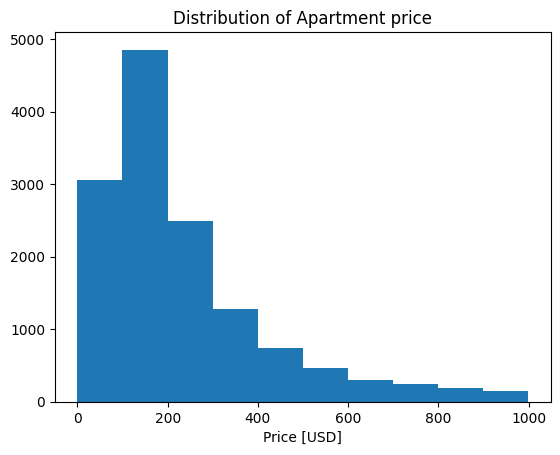

In [ ]:
# Distri

plt.hist(df["price"])
plt.xlabel("Price [USD]")
plt.title("Distribution of Apartment price")

<Axes: >

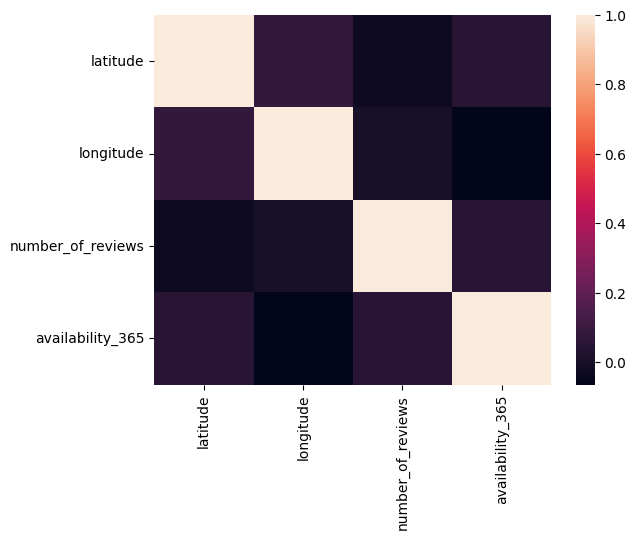

In [ ]:
# Plotting heatmap of the remaining numberical features in df

corr = df.select_dtypes("number").drop(columns="price").corr()
sns.heatmap(corr)

# as all of the review is related to each other, we only keep number of reviews

In [ ]:
# Plot Mapbox location and price
fig = px.scatter_mapbox(
    df, # data frame
    lat="latitude",
    lon="longitude",
    width=600,
    height=600,
    color="price",
    hover_data=["price"]

)
fig.update_layout(mapbox_style="open-street-map")

fig.show()

In [ ]:
df.head()

,latitude,longitude,price,number_of_reviews,availability_365
0,30.26057,-97.73441,176,630,298
1,30.45697,-97.78422,42,275,0
2,30.24885,-97.73587,109,122,0
3,30.26034,-97.76487,240,295,133
4,30.23466,-97.73682,85,48,36


## Split data

In [ ]:
from sklearn.model_selection import train_test_split

train, test = train_test_split(df, test_size=0.2)

df = train
test = test.to_csv('test.csv', index = False)

In [ ]:
# Split data into feature matrix `X_train` and target vector `y_train`.
target = "price"
features = ["latitude", "longitude", "number_of_reviews","availability_365"]
X_train = df[features]
y_train = df[target]

## Build model

In [ ]:
# Base line
y_mean = y_train.mean()
y_pred_baseline = [y_mean] * len(y_train)
baseline_mae = mean_absolute_error(y_train, y_pred_baseline)
print("Mean apt price:", y_mean)
print("Baseline MAE:", baseline_mae)

Mean apt price: 232.44606863991285
Baseline MAE: 137.8530992909993


In [ ]:
# Build Model
model = make_pipeline(
    # OneHotEncoder(use_cat_names=True),
    SimpleImputer(),
    Ridge(),
)
# Fit model
model.fit(X_train, y_train)

Pipeline(steps=[('simpleimputer', SimpleImputer()), ('ridge', Ridge())])

## Evaluate

In [ ]:
y_pred_training = model.predict(X_train)
print("Training MAE:", mean_absolute_error(y_train, y_pred_training))

Training MAE: 135.3076766525731


In [ ]:
X_test = pd.read_csv("test.csv").drop(columns=["price"])
print(X_test.info())
X_test.head()
y_test_pred = pd.Series(model.predict(X_test))
y_test_pred.head()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 2754 entries, 0 to 2753
Data columns (total 4 columns):
 #   Column             Non-Null Count  Dtype  
---  ------             --------------  -----  
 0   latitude           2754 non-null   float64
 1   longitude          2754 non-null   float64
 2   number_of_reviews  2754 non-null   int64  
 3   availability_365   2754 non-null   int64  
dtypes: float64(2), int64(2)
memory usage: 86.2 KB
None


0    218.212986
1    204.853577
2    275.533776
3    230.919214
4    249.661487
dtype: float64

In [ ]:
df.head()

,latitude,longitude,price,number_of_reviews,availability_365
4872,30.49286,-97.77089,69,0,0
1231,30.36865,-97.69854,75,64,216
7832,30.22529,-97.76071,97,41,360
9816,30.28049,-97.79991,349,33,273
3221,30.19494,-97.81458,200,0,0


## Communication


In [ ]:
def make_prediction(lat, lon, number_of_reviews,availability_365 ):
    data = {
        "latitude": lat,
        "longitude": lon,
        "number_of_reviews": number_of_reviews,
        "availability_365": availability_365
    }
    df = pd.DataFrame(data, index=[0])
    prediction = model.predict(df)
    return f"Predicted price per night: ${prediction}"

In [ ]:
make_prediction( 30.49286, -97.77089,100,50)

'Predicted price per night: $[175.69847553]'

In [ ]:
interact(
    make_prediction,
    lat=FloatSlider(
        min=X_train["latitude"].min(),
        max=X_train["latitude"].max(),
        step=0.01,
        value=X_train["latitude"].mean(),
    ),
    lon=FloatSlider(
        min=X_train["longitude"].min(),
        max=X_train["longitude"].max(),
        step=0.01,
        value=X_train["longitude"].mean(),
    ),
    number_of_reviews=IntSlider(
        min=X_train["number_of_reviews"].min(),
        max=X_train["number_of_reviews"].max(),
        value=X_train["number_of_reviews"].mean(),
    ),
    availability_365=IntSlider(
        min=X_train["availability_365"].min(),
        max=X_train["availability_365"].max(),
        value=X_train["availability_365"].mean(),
    ),
);

interactive(children=(FloatSlider(value=30.28104932043231, description='lat', max=30.50971, min=30.07887, step…

In [ ]:
coefficients = model.named_steps['ridge'].coef_
feat_imp = pd.Series(coefficients, index = features)
feat_imp

latitude            -191.684738
longitude           -298.975680
number_of_reviews     -0.136390
availability_365       0.141536
dtype: float64

Text(0.5, 1.0, 'Feature Importances for Apartment Price')

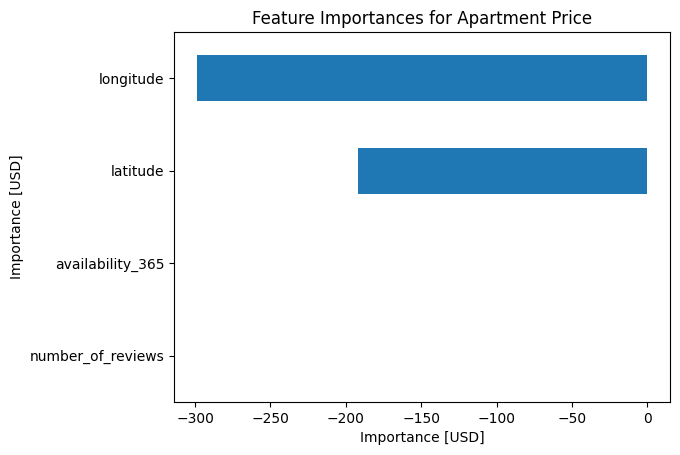

In [ ]:
# Finally, what is the feature that is the most important for the price per night
feat_imp.sort_values(key = abs).tail(10).plot(kind = 'barh')
plt.xlabel("Importance [USD]")
plt.ylabel("Importance [USD]")
plt.title('Feature Importances for Apartment Price')
